In [1]:
%matplotlib inline
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor

In [2]:
# load data
def load_data():
    working_folder = ".."
    data_folder = "data"
    format1_fdir = 'data_format1_20180930_20181007.h5'#data_format1_201808.h5'#923_20180930.h5'#
    format2_fdir = 'data_format2_20180930_20181007.h5'#data_format2_201808.h5'#923_20180930.h5'#

    format1_dir = os.path.join(working_folder, data_folder, format1_fdir)
    format2_dir = os.path.join(working_folder, data_folder, format2_fdir)

    sys.path.append(working_folder)

    f1_data = pd.HDFStore(format1_dir)
    keys = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
    series_avg = pd.DataFrame()
    for key in keys:
        series_avg[key] = (0.25 * (f1_data[key]['close'] + f1_data[key]['open'] + f1_data[key]['high'] + f1_data[key]['low']))
    # TODO add volume
    f1_data.close()
    return series_avg, keys

In [3]:
# define func
def train_test_split_self(data_x, data_y, test_size=0.33):
    size = len(data_x)
    train_size = int(len(data_x) * (1-test_size))
    return data_x[:train_size], data_x[train_size:], data_y[:train_size], data_y[train_size:]

In [108]:
# train model
def train_model(data_x, data_y, is_plot:bool=False, is_print:bool=False, shift_period=1):
    
    X_train, X_test, y_train, y_test = train_test_split_self(data_x, data_y, test_size=0.33)#, random_state=42)

    # Create linear regression object
#     regr = linear_model.LinearRegression()
    penalty = 100
    regr = linear_model.Ridge(alpha=penalty)
#     regr = MLPRegressor()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # The mean squared error
    mse = mean_squared_error(y_test, y_pred)
    # The mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    # Explained variance score: 1 is perfect prediction
    score = r2_score(y_test, y_pred)#regr.score(X_test, y_test)#

    if is_print:
        print("Mean squared error: %.2f" % mse)
        print('Variance score: %.2f' % score)
         # The coefficients
        print('Coefficients: \n', regr.coef_)
        print('Intercept: \n', regr.intercept_)

    # Plot outputs
    if is_plot:
        import matplotlib.style as style
        style.use('ggplot')
        fig = plt.figure(figsize=(10,3))
        x_axis = np.arange(len(X_test))
        ax1 = plt.plot(x_axis, y_test,  color='red', linewidth=1)#scatter(x_axis, y_test,  color='black')
        ax2 = plt.plot(x_axis, y_pred, color='blue', linewidth=1)
        plt.title(f'price change of real & pred\n@ shift_period={shift_period} penalty:{penalty}')
        plt.grid(True)
        plt.legend(['real', 'pred'])
        
        plt.xticks()
        plt.yticks()

        plt.show()
    
    
    return regr, {'mse':mse, 'score':score, 'mae': mae}

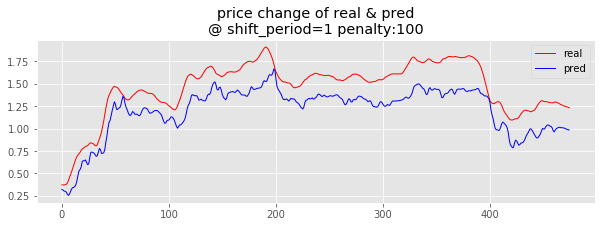

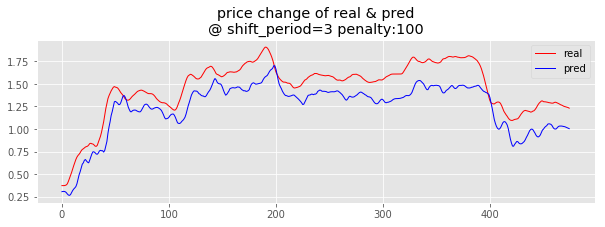

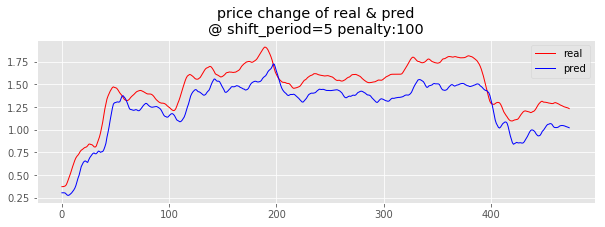

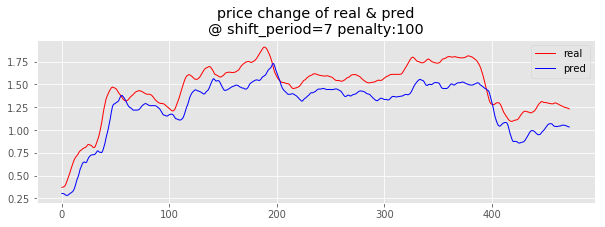

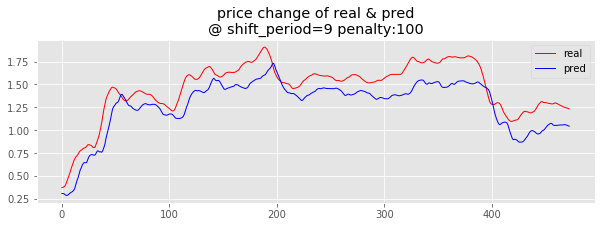

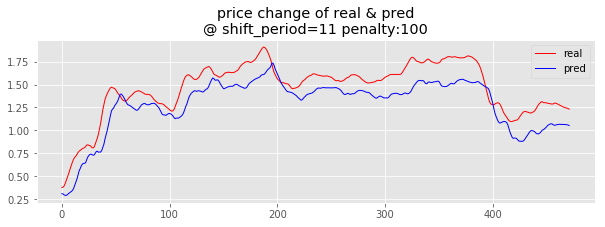

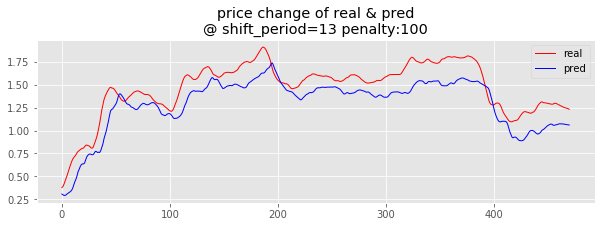

In [111]:
# load data
series_avg_org, keys = load_data()
# train model
shift_period = 1
data_length = 60 * 24 #24 * 60 * 2
asset = keys[1]

# do standardlize before using ridge
from sklearn import preprocessing
series_avg = pd.DataFrame()
for key in keys:
    series_avg[key] = (series_avg_org[key] - series_avg_org[key].mean())/ series_avg_org[key].std() 
    #preprocessing.scale(series_avg_org[key].values)
#     series_avg[key] = series_avg_org[key]

models_mse = dict()
models_mae = dict()
models_score = dict()

def get_rename_dict(t):
    return {'BCH-USD':'BCH-USD_%i'%t, 'BTC-USD':'BTC-USD_%i'%t, 'ETH-USD':'ETH-USD_%i'%t, 'LTC-USD':'LTC-USD_%i'%t}

# train
for asset in ['BTC-USD']:#keys
    mses = []
    maes = []
    scores = []
    models_mse[asset] = mses
    models_mae[asset] = maes
    models_score[asset] = scores
    for shift_period in range(1,15,2):
        # Load the diabetes dataset
        all_asset = keys.copy()
        # all_asset.remove(asset)
        data_x = series_avg[all_asset]

        for t in range(shift_period if shift_period > 1 else 1):
            t = t+1
#             print(f"shift {t}")
            data_x_t = series_avg[all_asset].shift(1 * t)
            data_x_t = data_x_t.rename(columns=get_rename_dict(t))
            data_x = data_x.join(data_x_t)
#         data_x = data_x.values[shift_period:]
        
        # shift forward the predict value, as using the price at 
#         data_y = series_avg[asset].shift(-1 * shift_period)[:-1*shift_period].values
        data_y = []
        for p in range(len(data_x)):
            data_y.append(series_avg[asset].iloc[p:p+10].mean())
        data_y = np.array(data_y)
        
        data_x = data_x[shift_period:data_length]
        data_y = data_y[shift_period:data_length]
        
        model, judge_dict = train_model(data_x, data_y, is_plot=True, is_print=False, shift_period=shift_period)
        
        mses.append(judge_dict['mse'])#  / model.intercept_)#math.sqrt(judge_dict['mse']) / model.intercept_)
        maes.append(judge_dict['mae'])#  / model.intercept_)
        scores.append(judge_dict['score'])
        
#         print(f"asset: {asset}, shift_period: {shift_period}")
#         print("Mean absolute error: %.2f" % judge_dict['mae'])
#         print('score: %.2f' % judge_dict['score'])
#         print('Coefficients: ', model.coef_)
#         print('Intercept: ', model.intercept_)
#         print('---------------------------------------')

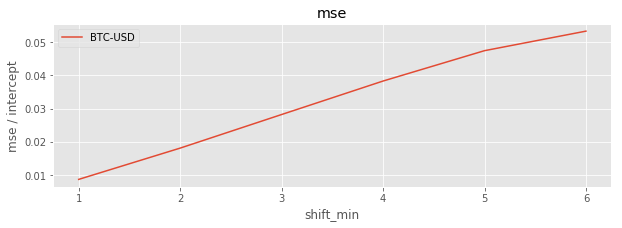

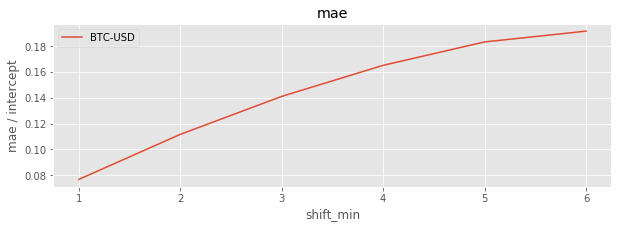

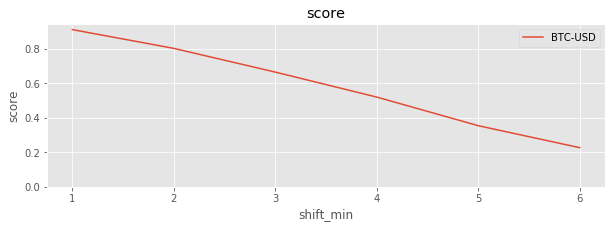

In [87]:
# plot
model_pd_mse = pd.DataFrame(models_mse)
model_pd_mae = pd.DataFrame(models_mae)
model_pd_score = pd.DataFrame(models_score)

x = [x+1 for x in range(len(model_pd_mse))]
model_pd_mse = model_pd_mse.reindex(x)
model_pd_mae = model_pd_mae.reindex(x)
model_pd_score = model_pd_score.reindex(x)

ax_mse = model_pd_mse.plot(figsize=(10, 3), title='mse')#, logy=True)
ax_mse.xaxis.label.set_text('shift_min')
ax_mse.yaxis.label.set_text('mse / intercept')

ax_mse = model_pd_mae.plot(figsize=(10, 3), title='mae')#, logy=True)
ax_mse.xaxis.label.set_text('shift_min')
ax_mse.yaxis.label.set_text('mae / intercept')

ax_score = model_pd_score.plot(figsize=(10, 3), title='score', ylim=0)
ax_score.xaxis.label.set_text('shift_min')
ax_score.yaxis.label.set_text('score')

In [26]:
# series_avg_copy = series_avg.copy()
# series_avg_copy[keys[3]] = series_avg[keys[3]].shift(-1 * 60 * 0)
# period=60*10
# series_avg_copy[:period].plot(figsize=(14,10), grid=True, subplots=True)
# # series_avg.corr()
# series_avg_copy[:period].corr()

In [42]:
?r2_score

In [13]:
?mean_absolute_error

In [91]:
series_avg[all_asset].head(20)

,BCH-USD,BTC-USD,ETH-USD,LTC-USD
time,,,,
2018-09-30 06:00:00,533.0450,6552.5125,230.2950,60.6575
2018-09-30 06:01:00,533.3000,6552.5150,230.1575,60.6600
2018-09-30 06:02:00,533.4450,6552.8850,230.1600,60.6300
2018-09-30 06:03:00,533.4500,6552.5300,230.1550,60.6775
2018-09-30 06:04:00,533.8950,6553.2700,230.1500,60.7450
2018-09-30 06:05:00,534.7600,6553.9975,230.2500,60.7450
2018-09-30 06:06:00,534.6700,6553.9950,230.3400,60.7400
2018-09-30 06:07:00,534.2775,6553.9975,230.3400,60.7300
2018-09-30 06:08:00,534.0200,6553.9925,230.3350,60.7175


In [165]:
shift_period = 3
asset = 'BTC-USD'
all_asset = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
data_x = series_avg[all_asset]
def get_rename_dict(t):
    return {'BCH-USD':'BCH-USD_%i'%t, 'BTC-USD':'BTC-USD_%i'%t, 'ETH-USD':'ETH-USD_%i'%t, 'LTC-USD':'LTC-USD_%i'%t}
for t in range(shift_period - 1):
    t = t+1
    data_x_t = series_avg[all_asset].shift(1 * t)
    data_x_t = data_x_t.rename(columns=get_rename_dict(t))
    data_x = data_x.join(data_x_t)
#data_x = data_x.values[:-1*t]
data_x.head()

,BCH-USD,BTC-USD,ETH-USD,LTC-USD,BCH-USD_1,BTC-USD_1,ETH-USD_1,LTC-USD_1,BCH-USD_2,BTC-USD_2,ETH-USD_2,LTC-USD_2
time,,,,,,,,,,,,
2018-09-30 06:00:00,533.045,6552.5125,230.2950,60.6575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 06:01:00,533.300,6552.5150,230.1575,60.6600,533.045,6552.5125,230.2950,60.6575,NaN,NaN,NaN,NaN
2018-09-30 06:02:00,533.445,6552.8850,230.1600,60.6300,533.300,6552.5150,230.1575,60.6600,533.045,6552.5125,230.2950,60.6575
2018-09-30 06:03:00,533.450,6552.5300,230.1550,60.6775,533.445,6552.8850,230.1600,60.6300,533.300,6552.5150,230.1575,60.6600
2018-09-30 06:04:00,533.895,6553.2700,230.1500,60.7450,533.450,6552.5300,230.1550,60.6775,533.445,6552.8850,230.1600,60.6300
